In [0]:
# @author: BOYU ZHANG
# GitHub: CristianoBY
# All Rights Reserved

# Convolutional Neural Network for Quick Draw graph recognition
# https://console.cloud.google.com/storage/browser/quickdraw_dataset/?pli=1
# I used the simplified data in form of numpy bitmap provided by Google and the Quick Draw AI Experiments
# https://quickdraw.withgoogle.com/data
# Trained in Google Colab

In [2]:
# upload small test class names: 3 items only
from google.colab import files

uploaded = files.upload()

Saving mini_classes.txt to mini_classes (2).txt


In [0]:
# load 100 random choices for graphs
file = open("mini_classes.txt","r")

# read in the choices
classes = file.readlines()
file.close()



In [0]:
# basic imports
import os
import urllib.request
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [5]:
# trim the array
classes = [c.replace('\n','').replace(' ','_') for c in classes]

for c in classes:
	print(c, '\n')

drums 

sun 

laptop 



In [6]:
# new dictionary for raw data
!mkdir raw_data

mkdir: cannot create directory ‘raw_data’: File exists


In [0]:
# get examples from google cloud
def get_object(bucket, filename, out_file):
    service = create_service()

    # Use get_media instead of get to get the actual contents of the object.
    # http://g.co/dv/resources/api-libraries/documentation/storage/v1/python/latest/storage_v1.objects.html#get_media
    req = service.objects().get_media(bucket = bucket, object = filename)

    downloader = http.MediaIoBaseDownload(out_file, req)

    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download {}%.".format(int(status.progress() * 100)))

    return out_file

# download the data 
def download_google_cloud():

	print('Begin to downlad raw data')

	for c in classes:

		c.replace('_',' ')

		out_file_name = 'raw_data/' + c + '.npy'
		bucket = 'https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1'

		filename = c + '.npy'
		get_object(bucket = bucket, filename = filename, out_file = out_file_name)

In [8]:
# download the data 
def download_data():

	print('Begin to downlad raw data')
	address = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

	for c in classes:
		name = c.replace('_', '%20')
		final_addr = address+ name +'.npy'
		print(final_addr)
		urllib.request.urlretrieve(final_addr, 'raw_data/' + c + '.npy')

download_data()

Begin to downlad raw data
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy


In [0]:
# only 4000 training samples for each example drawing
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):

    all_files = glob.glob(os.path.join(root, '*.npy'))

    # initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    # load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    # randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    # separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [10]:
x_train, y_train, x_test, y_test, class_names = load_data('raw_data')
num_classes = len(class_names)
image_size = 28

# expecting to see 400000
print(len(x_train))

9600


laptop


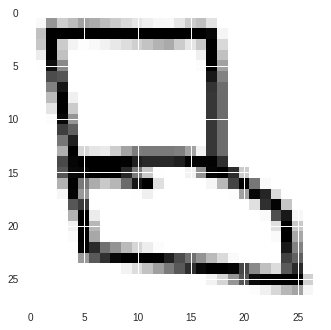

In [11]:
# shwo one random example with 28x28 gray scale graph
import matplotlib.pyplot as plt
from random import randint

idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [0]:
# Reshape and normalize the dataset
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define model with CNN
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], 
                        activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), 
						padding='same', 
						activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), 
						padding='same', 
						activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax')) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

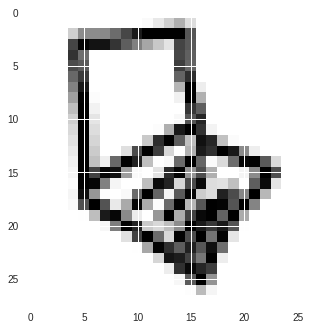

In [14]:
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

 # test the accuracy by a random test example
 # showing the process of all predictions
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print("Prediction Results sorted by Possibility (high to low)", latex)